1. We will be using tree based models. (Since the dataset is imbalanced)
2. Aim would be to create a model with low type-II error.
3. We will try out different feature selection techniques and compare their performance.
4. we will use hyperparameter tunning to improve model performance furthur.

In [97]:
! pip install category_encoders
! pip install skfeature-chappers

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
feature_selection = {
    'Technique' : list(),
    'data'      : list()
}

In [100]:
try:
  df = pd.read_csv('../data/raw_data.csv')
except Exception as e:
  df = pd.read_csv('https://raw.githubusercontent.com/soil15/Customer_churn/main/data/raw_data.csv')


df.drop('Unnamed: 0', axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [101]:
df.shape

(4250, 20)

#### Feature selection techiniques
    1. PCA and chi_square
    2. Fisher score
    3. Random forest importance

In [102]:
num_cols = [col for col in df.columns if df[col].dtypes != 'object']
cat_cols = [col for col in df.columns if ( df[col].dtypes == 'object' and col != 'churn' ) ]

In [103]:
cat_cols, num_cols

(['state', 'area_code', 'international_plan', 'voice_mail_plan'],
 ['account_length',
  'number_vmail_messages',
  'total_day_minutes',
  'total_day_calls',
  'total_day_charge',
  'total_eve_minutes',
  'total_eve_calls',
  'total_eve_charge',
  'total_night_minutes',
  'total_night_calls',
  'total_night_charge',
  'total_intl_minutes',
  'total_intl_calls',
  'total_intl_charge',
  'number_customer_service_calls'])

In [104]:
num_df = df[num_cols]

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [106]:
std_scalar = StandardScaler()
num_df = std_scalar.fit_transform(num_df)

In [107]:
pca = PCA()

num_df = pca.fit_transform(num_df)

num_df = pd.DataFrame(data=num_df)

In [108]:
pca.explained_variance_ratio_

array([1.37360294e-01, 1.34779222e-01, 1.31804605e-01, 1.29866408e-01,
       6.92152057e-02, 6.82530560e-02, 6.72887752e-02, 6.62161372e-02,
       6.54312241e-02, 6.53725059e-02, 6.44120040e-02, 4.90337267e-07,
       5.31571224e-08, 1.51577275e-08, 3.20417659e-09])

In [109]:
np.cumsum(pca.explained_variance_ratio_)

array([0.13736029, 0.27213952, 0.40394412, 0.53381053, 0.60302574,
       0.67127879, 0.73856757, 0.8047837 , 0.87021493, 0.93558743,
       0.99999944, 0.99999993, 0.99999998, 1.        , 1.        ])

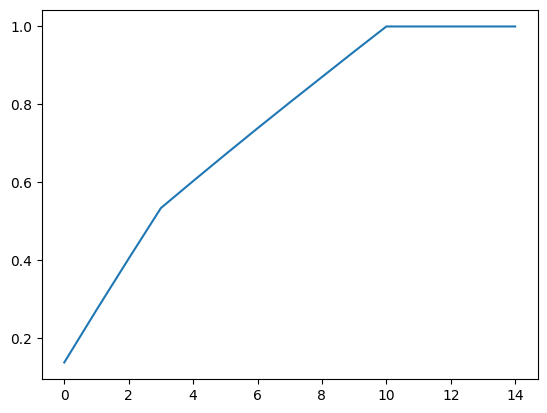

In [110]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

<p> As we can see after 10th feature there is not any significant increase in variance ratio, we can drop last 4 columns </p>

In [111]:
pca_df = num_df.iloc[:, 0:11]
pca_df.shape

(4250, 11)

In [112]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [113]:
label_encoder = LabelEncoder()

df['international_plan'] = label_encoder.fit_transform(df['international_plan'])

df['voice_mail_plan'] = label_encoder.fit_transform(df['voice_mail_plan'])

df['churn'] = label_encoder.fit_transform(df['churn'])

df['area_code'] = label_encoder.fit_transform(df['area_code'])

In [114]:
target_encoder = ce.TargetEncoder()

df['state'] = target_encoder.fit_transform(X=df['state'], y=df['churn'])

In [115]:
chi_df = df[cat_cols]

In [116]:
chi2_features = SelectKBest(chi2, k=3)

chi_df = pd.DataFrame(data=chi2_features.fit_transform(chi_df, df['churn']))

In [117]:
chi_df.head()

,0,1,2
0,0.126324,0.0,1.0
1,0.270768,0.0,0.0
2,0.126324,1.0,0.0
3,0.204934,1.0,0.0
4,0.157287,0.0,1.0


In [118]:
chi_df.columns

RangeIndex(start=0, stop=3, step=1)

In [119]:
chi_df.rename(columns={0 : 11, 1 : 12, 2 : 13}, inplace=True)

chi_df

,11,12,13
0,0.126324,0.0,1.0
1,0.270768,0.0,0.0
2,0.126324,1.0,0.0
3,0.204934,1.0,0.0
4,0.157287,0.0,1.0
...,...,...,...
4245,0.212322,0.0,0.0
4246,0.136691,0.0,0.0
4247,0.087632,0.0,0.0
4248,0.052244,0.0,1.0


In [120]:
pca_chi_df = pd.concat([pca_df, chi_df, df['churn']], axis=1)

In [121]:
pca_chi_df.shape

(4250, 15)

In [122]:
pca_chi_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,churn
0,-0.323532,-2.114335,0.997691,-0.595870,0.716353,-0.385573,-0.486884,-0.768171,0.624777,-1.156578,0.578314,0.126324,0.0,1.0,0
1,1.152404,-0.908546,-2.582522,-0.991371,1.485336,0.042210,0.333017,-0.108044,-0.548141,-0.477670,-0.753473,0.270768,0.0,0.0,0
2,4.487852,0.084481,-2.868648,0.415481,-0.714418,-0.322802,-0.042247,0.628538,-0.157387,1.792099,-0.312051,0.126324,1.0,0.0,0
3,0.323781,-0.588118,-1.078581,0.874012,-0.503538,0.754610,0.255352,0.696681,-0.970436,-1.302649,1.017095,0.204934,1.0,0.0,0
4,-0.491747,3.185081,2.858775,-1.451932,0.079653,-0.305771,-0.657684,1.836406,0.982945,0.010437,0.600872,0.157287,0.0,1.0,0


In [123]:
feature_selection['Technique'].append('pca_chi_squre')
feature_selection['data'].append(pca_chi_df)

In [124]:
feature_selection['Technique'].append('No_fe_sel')
feature_selection['data'].append(df)

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [126]:
X = df.drop(['churn'], axis=1)
y = df['churn']

In [127]:
model = RandomForestClassifier()

model.fit(X, y)

RandomForestClassifier()

In [128]:
model.feature_importances_

array([0.03185836, 0.02821757, 0.00717974, 0.07728557, 0.02070021,
       0.0293439 , 0.14163817, 0.02763625, 0.14834785, 0.05964738,
       0.02391746, 0.06562393, 0.03751018, 0.02664917, 0.03615172,
       0.03841857, 0.04685581, 0.03816242, 0.11485574])

In [129]:
feature_importance = {
    'Features' : X.columns,
    'Importance' : model.feature_importances_ * 100
}

In [130]:
imp_df = pd.DataFrame(data=feature_importance)
imp_df = imp_df.sort_values(ascending=False, by='Importance')

imp_df

,Features,Importance
8,total_day_charge,14.834785
6,total_day_minutes,14.163817
18,number_customer_service_calls,11.485574
3,international_plan,7.728557
11,total_eve_charge,6.562393
9,total_eve_minutes,5.964738
16,total_intl_calls,4.685581
15,total_intl_minutes,3.841857
17,total_intl_charge,3.816242
12,total_night_minutes,3.751018


<ipython-input-131-b0fcbabcf102>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=imp_df, x='Importance', y='Features', palette='rocket')


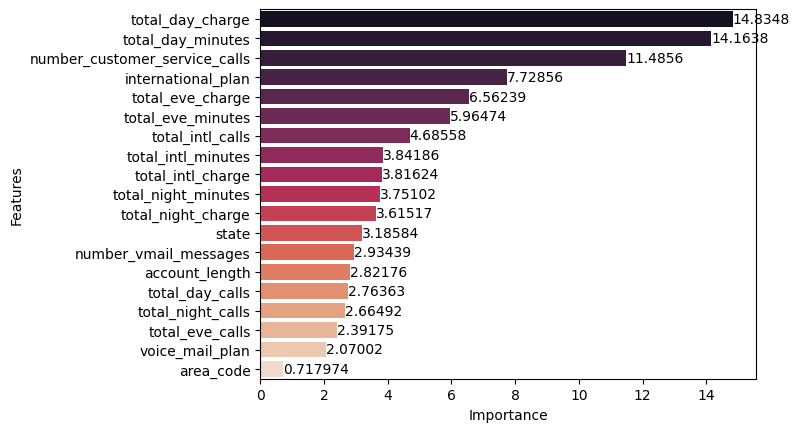

In [131]:
# imp_df.sort_values(ascending=False, by='Importance').plot.bar()

ax = sns.barplot(data=imp_df, x='Importance', y='Features', palette='rocket')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

<p1>We will set a threshold of '2.5'. we will drop features with importance less that '2.5'</p1>

In [132]:
selected_features = list(imp_df['Features'][imp_df['Importance'] > 2.5])

In [133]:
imp_df = df[selected_features].copy()
imp_df['churn'] = df['churn']
imp_df.head()

,total_day_charge,total_day_minutes,number_customer_service_calls,international_plan,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_minutes,total_intl_charge,total_night_minutes,total_night_charge,state,number_vmail_messages,account_length,total_day_calls,total_night_calls,churn
0,27.47,161.6,1,0,16.62,195.5,3,13.7,3.70,254.4,11.45,0.126324,26,107,123,103,0
1,41.38,243.4,0,0,10.30,121.2,5,12.2,3.29,162.6,7.32,0.270768,0,137,114,104,0
2,50.90,299.4,2,1,5.26,61.9,7,6.6,1.78,196.9,8.86,0.126324,0,84,71,89,0
3,28.34,166.7,3,1,12.61,148.3,3,10.1,2.73,186.9,8.41,0.204934,0,75,113,121,0
4,37.09,218.2,3,0,29.62,348.5,7,7.5,2.03,212.6,9.57,0.157287,24,121,88,118,0


In [134]:
imp_df.shape

(4250, 17)

In [135]:
feature_selection['Technique'].append('Rand_imp')
feature_selection['data'].append(imp_df)

In [136]:
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt

In [137]:
X = np.array(df.drop('churn', axis=1))
y = df['churn']

In [138]:
ranks = fisher_score.fisher_score(X, y)
feat_imp = pd.Series(ranks, df.columns[0:len(df.columns) - 1])

/usr/local/lib/python3.10/dist-packages/skfeature/utility/construct_W.py:194: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]


In [139]:
feat_imp.index

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')

In [140]:
feat_dict = {
    'Features' : list(),
    'Fisher_score' : list(),
}

In [141]:
feat_dict['Features'] = feat_imp.index
feat_dict['Fisher_score'] = feat_imp.values

In [142]:
feat_df = pd.DataFrame(data=feat_dict)
feat_df

,Features,Fisher_score
0,state,15
1,account_length,0
2,area_code,12
3,international_plan,10
4,voice_mail_plan,18
5,number_vmail_messages,14
6,total_day_minutes,13
7,total_day_calls,9
8,total_day_charge,7
9,total_eve_minutes,3


<ipython-input-155-5afacd0ece98>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feat_df, x='Fisher_score', y='Features', palette='rocket')


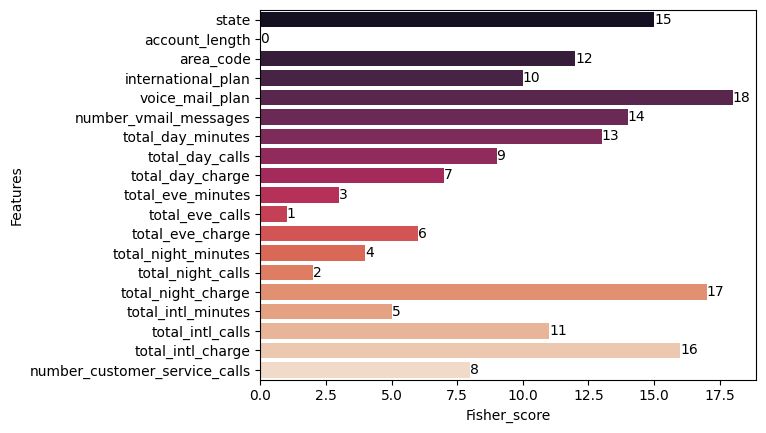

In [155]:
ax = sns.barplot(data=feat_df, x='Fisher_score', y='Features', palette='rocket')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

<p1>We will pick top 14 featuers</p1>

In [144]:
fisher_df = df[feat_df['Features'][feat_df['Fisher_score'] >= 5]].copy()

In [145]:
fisher_df['churn'] = df['churn']

In [146]:
fisher_df.head()

,state,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_charge,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,0.126324,1,0,1,26,161.6,123,27.47,16.62,11.45,13.7,3,3.70,1,0
1,0.270768,1,0,0,0,243.4,114,41.38,10.30,7.32,12.2,5,3.29,0,0
2,0.126324,0,1,0,0,299.4,71,50.90,5.26,8.86,6.6,7,1.78,2,0
3,0.204934,1,1,0,0,166.7,113,28.34,12.61,8.41,10.1,3,2.73,3,0
4,0.157287,2,0,1,24,218.2,88,37.09,29.62,9.57,7.5,7,2.03,3,0


In [147]:
feature_selection['Technique'].append('Fisher_score')
feature_selection['data'].append(fisher_df)

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score

In [149]:
models = {
    'Random_forest' : RandomForestClassifier(),
    'Gradient_boost' : GradientBoostingClassifier(),
    'xgb' : XGBClassifier()
}

In [150]:
perform_dict = {
    'Model' : list(),
    'Technique' : list(),
    'F1_score' : list(),
    'recall_score' : list(),
    'precision_score' : list()
}

In [151]:
list(feature_selection.values())[0]

['pca_chi_squre', 'No_fe_sel', 'Rand_imp', 'Fisher_score']

In [152]:
for model_name, model in zip(list(models.keys()), list(models.values())):

    for technique, data in zip(list(feature_selection.values())[0], list(feature_selection.values())[1]):

        X = data.drop('churn', axis=1)
        y = data['churn']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        perform_dict['Model'].append(model_name)
        perform_dict['Technique'].append(technique)
        perform_dict['F1_score'].append(f1_score(y_test, y_pred) * 100)
        perform_dict['precision_score'].append(precision_score(y_test, y_pred) * 100)
        perform_dict['recall_score'].append(recall_score(y_test, y_pred) * 100)


In [153]:
perform_df = pd.DataFrame(data=perform_dict)

In [154]:
perform_df

,Model,Technique,F1_score,recall_score,precision_score
0,Random_forest,pca_chi_squre,47.794118,32.663317,89.041096
1,Random_forest,No_fe_sel,82.857143,72.864322,96.026490
2,Random_forest,Rand_imp,84.090909,74.371859,96.732026
3,Random_forest,Fisher_score,81.920904,72.864322,93.548387
4,Gradient_boost,pca_chi_squre,53.424658,39.195980,83.870968
5,Gradient_boost,No_fe_sel,81.920904,72.864322,93.548387
6,Gradient_boost,Rand_imp,82.352941,73.869347,93.037975
7,Gradient_boost,Fisher_score,80.000000,70.351759,92.715232
8,xgb,pca_chi_squre,62.500000,50.251256,82.644628
9,xgb,No_fe_sel,81.481481,71.859296,94.078947
